In [107]:
from IPython import display
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm import tqdm
from pylab import rcParams
import warnings
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot
from pmdarima.arima import auto_arima
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 15, 4

### Prepare the file

In [108]:
df_electric = pd.read_csv('data/Electric_Production.csv')
df_electric = df_electric.iloc[:-1]
df_electric.rename(columns = {'IPG2211A2N':'amount','DATE':'date'}, inplace = True)
# remove the last row of 2017 
df_electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    396 non-null    object 
 1   amount  396 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [109]:
df_electric['date'] = pd.to_datetime(df_electric['date'])
df_electric['year'] = df_electric['date'].apply(lambda x: x.year)
df_electric['month'] = df_electric['date'].apply(lambda x: x.month)
df_electric.set_index('date', inplace=True)
df_electric = df_electric.resample('M').mean()
df_electric['month_name'] = df_electric.index.strftime('%b')
df_electric.head()

,amount,year,month,month_name
date,,,,
1985-01-31,72.5052,1985.0,1.0,Jan
1985-02-28,70.6720,1985.0,2.0,Feb
1985-03-31,62.4502,1985.0,3.0,Mar
1985-04-30,57.4714,1985.0,4.0,Apr
1985-05-31,55.3151,1985.0,5.0,May


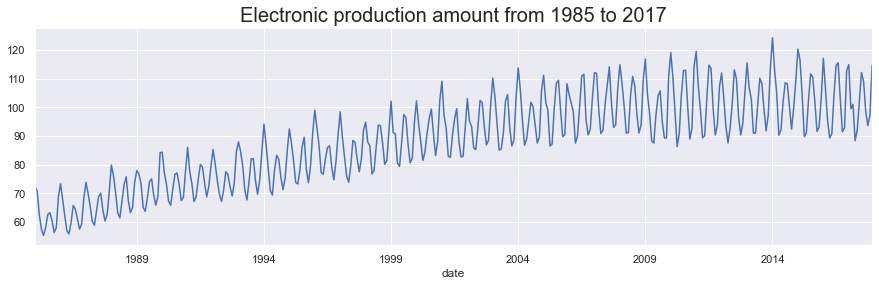

In [110]:
plt.figsize=(12, 4)

fig = df_electric['amount'].plot();
fig.set_title("Electronic production amount from 1985 to 2017",fontsize=20);

Through analyzing the graph, the graph showed the increasing trend of amount starting from 1985 while it is seems to be stopped increasing in 2009 and keep stable afterwards.

### Time series month analysis

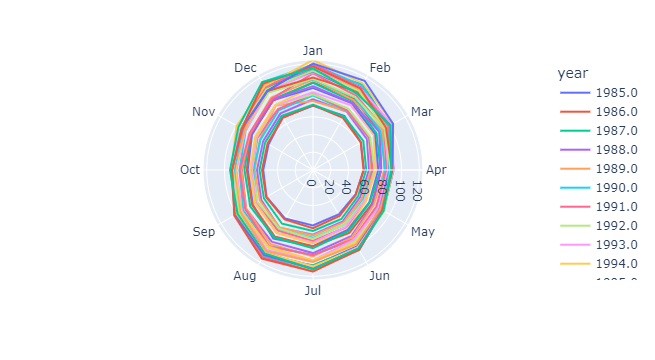

In [111]:
fig = make_subplots(rows=1, cols=2)

fig = px.line_polar(df_electric, r="amount", theta="month_name", color="year", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Plotly)
fig.show()

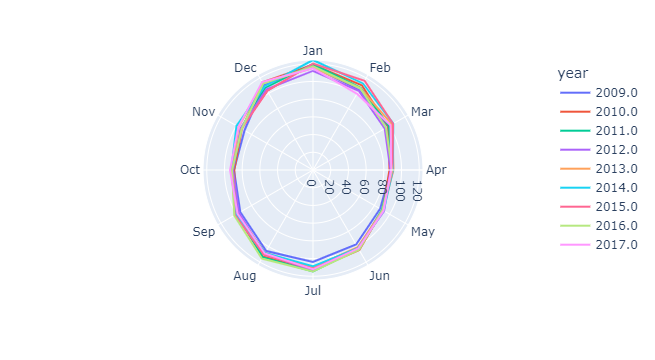

In [112]:
df_electric_past_9_year = df_electric[df_electric['year'] >= 2009]
fig = px.line_polar(df_electric_past_9_year, r="amount", theta="month_name", color="year", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Plotly)
fig.show()

As the polar graph shown, the width of 2009-2017 year circle is much more thinner regarding to all years. The amounts has no large changes during the following period and might appear the constant mean and variance.

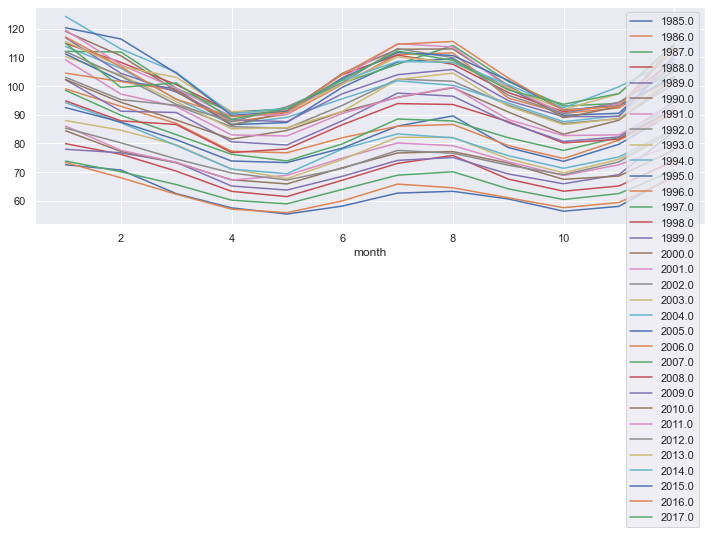

In [113]:
years = df_electric.year.unique()
fig, ax = plt.subplots(figsize=(12, 4))
for year in years:
    df = df_electric[df_electric['year'] == year]
    df.plot(x='month', y='amount', ax=ax);
plt.legend(years);

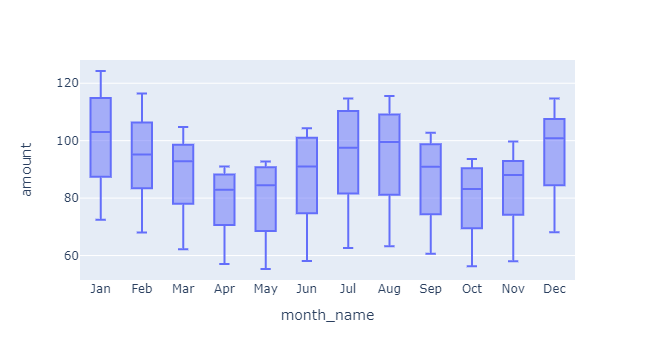

In [114]:
fig = px.box(df_electric, x="month_name", y="amount")
fig.show()

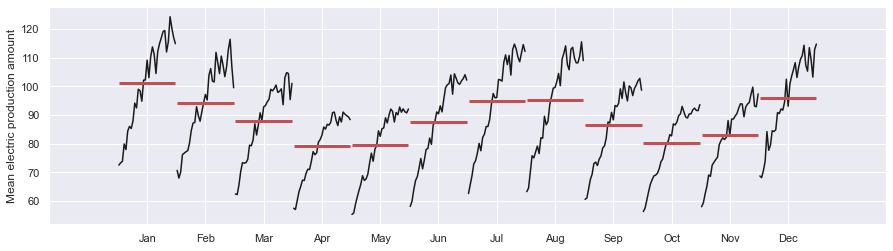

In [115]:

month_plot(df_electric["amount"], ylabel='Mean electric production amount');

For the above plots, there appears an obivous seasonal trend with a "W" sign trends.

skewness of distribution -0.10241577380874956


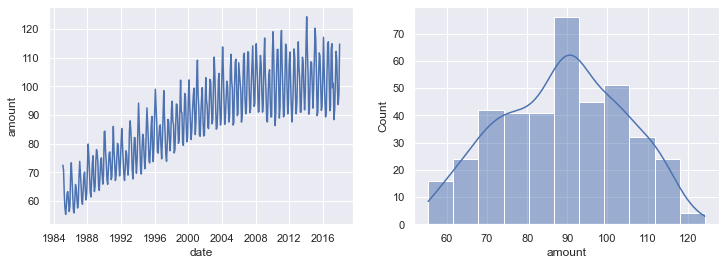

In [116]:
def hist_plots(ts):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot()
    sns.lineplot(data=ts, ax=ax[0]);
    sns.histplot(data=ts, ax=ax[1], kde=True);
    print("skewness of distribution", ts.skew())

hist_plots(df_electric['amount'])

skewness of distribution -0.05409265582288908


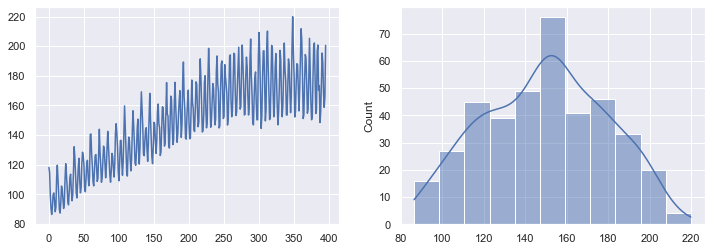

In [117]:
pt = PowerTransformer(method='box-cox', standardize=False)
box_cox_close = pd.Series(pt.fit_transform(df_electric['amount'].to_numpy().reshape(-1, 1)).ravel())
hist_plots(box_cox_close)

The data distribution is close to normal distribution even it is transformed by box-cox transformation as the skewness value is close to 0.

To illustrate the trend by using windows methods, it would be nice to use simple moving average and exponential moving average methods and the formulas are:
<br><br>
    $$\text{SMA}(t) = \frac{1}{n} \sum_{k=0}^{n-1} y_{t-k} $$ <br>
   <br>$$ \text{EMA}(t) = \frac{1}{1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{n-1}}\sum_{k=0}^{t-1} (1 - \alpha)^k y_{t-k} $$ <br>

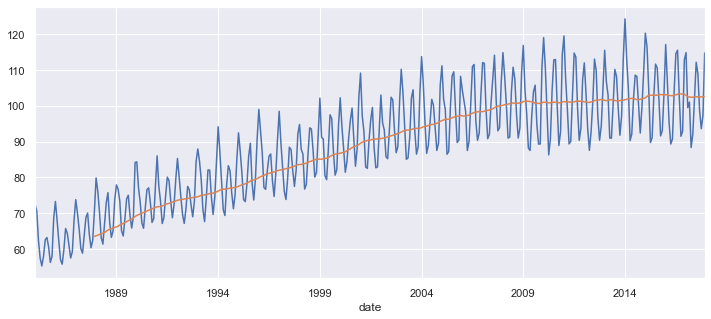

In [118]:
plt.figure(figsize=(12, 5))
df_electric['amount'].plot();
df_electric['amount'].rolling(36).mean().plot();

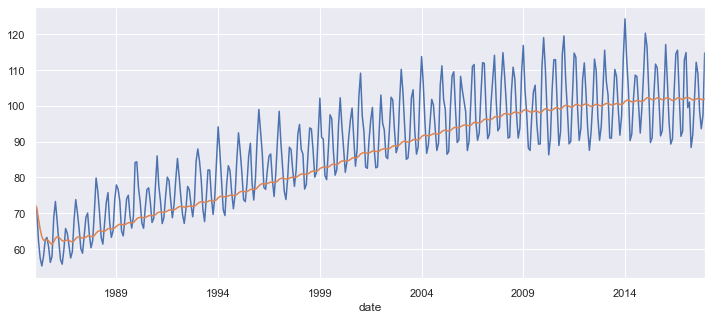

In [119]:
plt.figure(figsize=(12, 5))
df_electric['amount'].plot();
df_electric['amount'].ewm(alpha=0.025).mean().plot();

### Time series decomposition

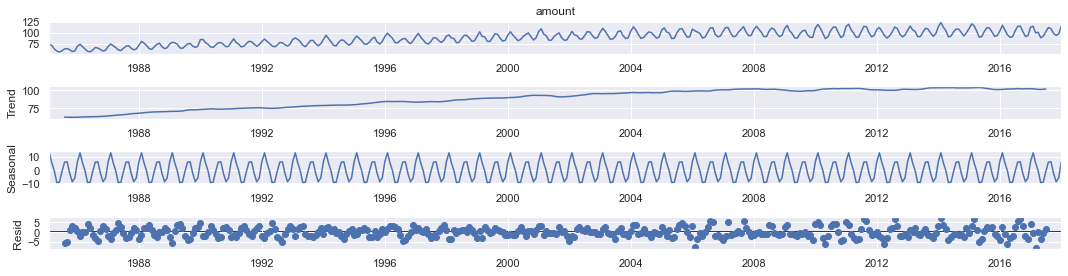

In [120]:
components = seasonal_decompose(df_electric['amount'], model='additive',period=12);
components.plot();

### White noise distribution

count    384.000000
mean      -0.023789
std        2.591165
min       -8.118199
25%       -1.913455
50%       -0.175396
75%        1.897486
max        7.237084
Name: resid, dtype: float64


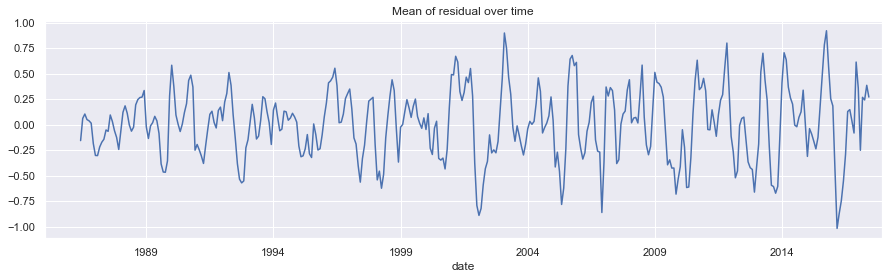

In [121]:
mean = components.resid.rolling(12).mean()
print(components.resid.describe())
mean.plot()
plt.title("Mean of residual over time");


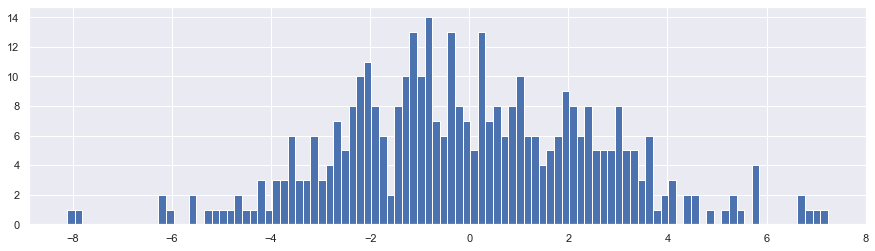

In [122]:
components.resid.hist(bins=100);

To verify the stationarity of time series data,
one of the most common way is to apply Augmented Dickey Fuller Test (ADF Test). Simply talking the concept, the test is to prove the existence of unit root. The time series data is stationary if it is not exist and null hypothesis will be rejected.


In [123]:
adf_result = adfuller(df_electric['amount'])
print('ADF Statistic: %f' % adf_result[0])
print('MacKinnon approximate p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.581844
MacKinnon approximate p-value: 0.096808
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Setting the 𝛼 = 0.05, unfortunately the null hypothesis can't be rejected.

The stationarity function with more details including mean and variance.


Refer to:
https://github.com/jiwidi/time-series-forecasting-with-python/blob/master/01-Analysis%26transforms.ipynb


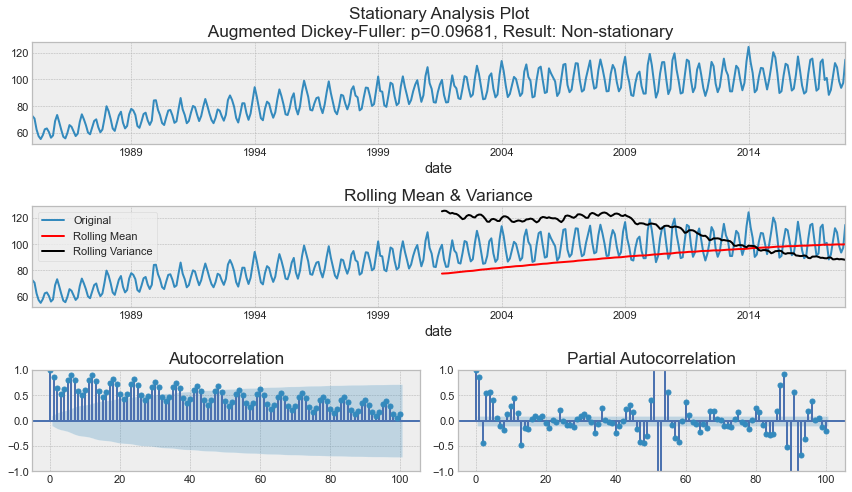

In [124]:
# function to summarise stationary test
def adf_test_and_tsplot(y, lags=100, figsize=(12, 7), syle='bmh', rolling_window=200):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):    # style from Probabilistic Programming and Bayesian Methods for Hackers;
        # define figure layout
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        rol_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0), colspan=1)
        pacf_ax = plt.subplot2grid(layout, (2, 1), colspan=1)
        
        # plot original series
        y.plot(ax=ts_ax)
        
        # ADF test and print result
        p_value = adfuller(y)[1]
        hypothesis_result = "Stationary" if p_value <= 0.05 else "Non-stationary"
        ts_ax.set_title(
            'Stationary Analysis Plot\n Augmented Dickey-Fuller: p={0:.5f}, Result: {1}'.format(p_value, hypothesis_result))
        
        # Plot rolling statistics:
        rolmean = y.rolling(window=rolling_window).mean()
        rolvar = y.rolling(window=rolling_window).var()
        y.plot(label='Original', ax=rol_ax)
        rolmean.plot(color='red', label='Rolling Mean', ax=rol_ax)
        rolvar.plot(color='black', label='Rolling Variance', ax=rol_ax)
        rol_ax.legend(loc='best')
        rol_ax.set_title('Rolling Mean & Variance')

        # ACF plot
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

adf_test_and_tsplot(df_electric['amount'], lags=100);

Since the stationarity is not achieved, applying logarithm transformation to see whether it goes that way...

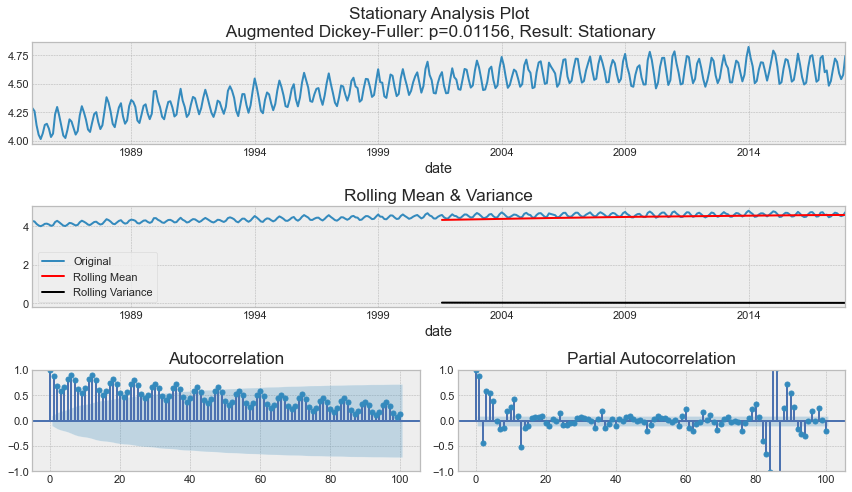

In [125]:
ts_transform = np.log(df_electric['amount'])
adf_test_and_tsplot(ts_transform, lags=100);

The time series data is stationary after logarithm transformed.

### Time series modelling

The prediction period ranges from 2012 to 2017 so the training time series data would be the previous years of 2012 record in order to achieve 80/20 splitting 

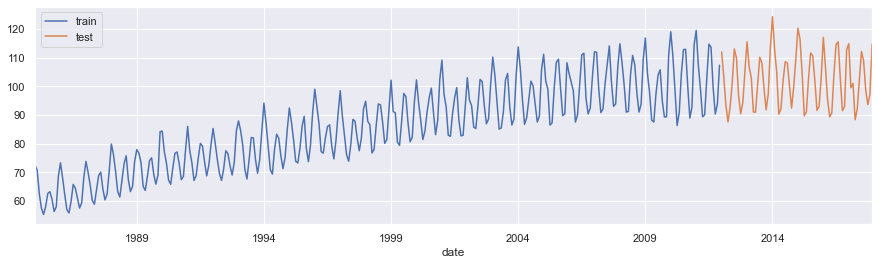

In [126]:
df = df_electric['amount']

# train test split
# prediction on year 2013 to 2017
df_train = df[df.index<'01-01-2012']
df_test = df[df.index>='01-01-2012']

def plot_ts(s_train=df_train, s_test=df_test, s_pred=None, ax=None, fit_params=None):
    
    s_train.plot(label='train', ax=ax);
    s_test.plot(label='test', ax=ax);
    if isinstance(s_pred, pd.Series):
        s_pred.plot(label='predict', ax=ax);
    if ax is not None:
        ax.legend(loc='upper right');
        ax.set_title(fit_params);
    else:
        plt.legend();
plot_ts()

Make it simple, the one-step forecasting is our goal and some functions are written to convenient us to make the prediction and evaluate the prediction result for each models.

In [127]:
prediction = {}
evaluation = {}

def evaluate(ytrue, ypred):
    scores = {
        'mae': mean_absolute_error(ytrue, ypred),
        'rmse': np.sqrt(mean_squared_error(ytrue, ypred)),
        'r2': r2_score(ytrue, ypred),
        'mape': mean_absolute_percentage_error(ytrue, ypred)
    }
    return scores

In [128]:
def ts_one_step_forecast(model, model_abbr, model_params={}, fit_params={}, ax=None):
    # rolling forecast
    ypred = list()
    for t in tqdm(range(len(df_test))):
        temp_train = df[:len(df_train)+t]
        m = model(temp_train, **model_params)
        fit = m.fit(**fit_params)
        predictions = fit.predict(start=len(temp_train), end=len(temp_train))    # returan a series
        ypred = ypred + [predictions]                                            # list of series

    # save result
    ypred = pd.concat(ypred)

    prediction[model_abbr] = ypred
    evaluation[model_abbr] = evaluate(df_test, ypred)

    # show result
    plot_ts(s_pred=ypred, ax=ax, fit_params=fit_params)
    
    return fit

### Exponential Smoothing models

The exponential smoothing models would be great to use as it can remove some random noise and the model can be effectively fitted through tuning the smoothing parameter. By applying the weighted average, the past observation value and predicted value compares each other to understand which one is important

We will use the following exponential smoothing models to do the forecasting:

- Simple exponential smoothing
- Double Exponential Smoothing / Holt's Linear Trend Method
- Damped Trend Method
- Triple Exponential Smoothing / Holt Winter’s Exponential Smoothing (HWES)

### Simple exponential smoothing (SES)

The formula of SES is:
$$ \hat{y}_{t+1} = \alpha y_{t} + (1 - \alpha) \hat{y}_{t} $$<br>

The idea is to use previous observation value and predicted value to make the one-step prediction. The $\alpha$ is the only smoothing parameter for tuning. Therefore, it would be good to predict if the time series has no obvious trend or seasonality

100%|██████████| 72/72 [00:00<00:00, 99.01it/s] 


{'smoothing_level': 0.9999999850677834,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 72.50477260436404,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

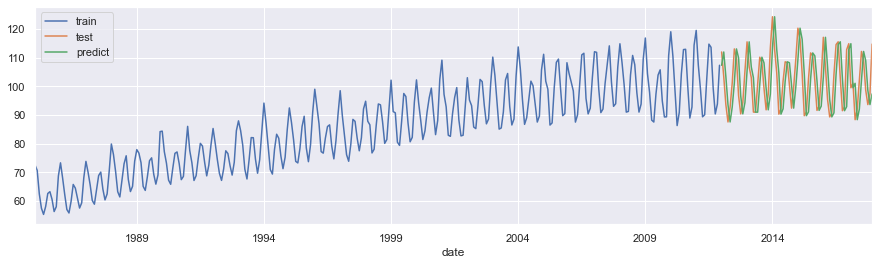

In [129]:
fit_params = {'optimized': True}
fit_ses = ts_one_step_forecast(SimpleExpSmoothing, 'SES', fit_params=fit_params)
fit_ses.params

### Double Exponential Smoothing / Holt's Linear Trend Method

The Holt's Linear Trend Method formula consist two parts which is level and trend components and those formulas are given by:

For level component:

$$ l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1}) $$ <br>

For trend component:

$$ b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1} $$ <br>

Combine the two components would become:


$$ \hat{y}_{t+h} = l_t + hb_t $$

(The ${h}$ means the numbers of prediction step so here is just ${l_t + b_t}$ as only one-step prediction planned to make)<br>

The Holt's Linear Trend Method aims to smooth the linear trend by tuning two parameters to control the strength of trend component.



100%|██████████| 72/72 [00:02<00:00, 34.34it/s]


{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 72.44237493248536,
 'initial_trend': 0.06302170142833995,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

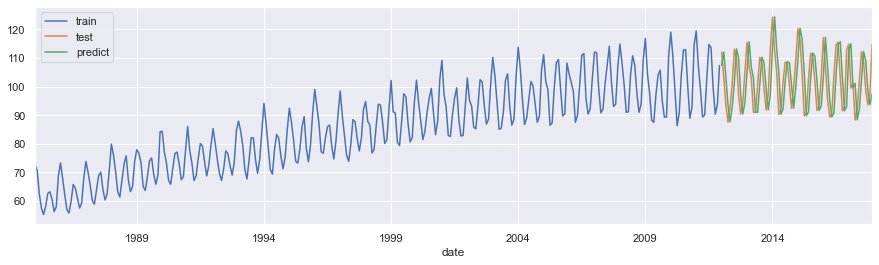

In [130]:
model_params = {'initialization_method': 'estimated'}
fit_hlt = ts_one_step_forecast(Holt, 'HLT', model_params=model_params, fit_params=fit_params)
fit_hlt.params

### Damped trend exponential smoothing method

This exponential smoothing method is to prevent the trend component keep increasing or decreasing. Similar to the previous double exponential smoothing, the ${h}$ value of DES is replaced by dumped value parameter $\phi$, where $0 < \phi < 1$:<br><br>
The formula is :
$$
        \begin{equation}
            \hat{y}_{t+h} = l_t + (\phi + \phi^2 +... + \phi^h)b_t \\
            l_t = \alpha y_t + (1-\alpha)(l_{t-1} + \phi b_{t-1}) \\
            b_t = \beta(l_t - l_{t-1}) + (1-\beta)\phi b_{t-1} 
        \end{equation}
    $$<br>

100%|██████████| 72/72 [00:02<00:00, 33.07it/s]


{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': 0.8213978699954482,
 'initial_level': 74.41308879645327,
 'initial_trend': -3.3020441108293506,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

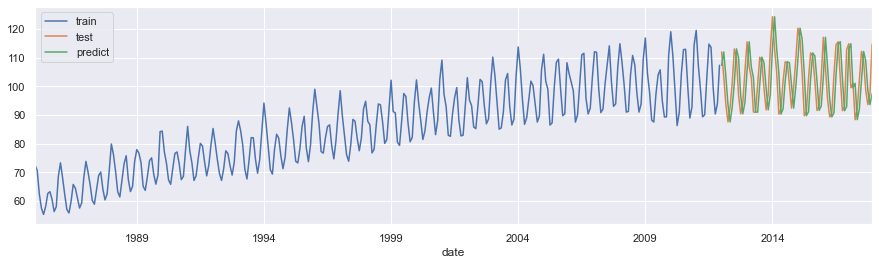

In [131]:
model_params = {'damped_trend': True}
fit_params = {'optimized': True}
fit_hlt_damped = ts_one_step_forecast(Holt, 'HLT_damped', model_params=model_params, fit_params=fit_params)
fit_hlt_damped.params

#### Triple Exponential Smoothing / Holt Winter’s Exponential Smoothing (HWES)
#### (Additive method)
The HWES consist of three components which is level, trend and seasonality so it smooths the time series with three times. So there would have three smoothing paramters. In general, it also accounts for the trend and seasonal to be additive or multiplicative.

The additive level component formula:

$$ l_t = \alpha(y_t - s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1}) $$ <br>

The additive trend component formula:

$$ b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1} $$ <br>

The additive seasonal component formula:

$$ s_t = \gamma (y_t - l_{t-1} - b_{t-1}) + (1-\gamma)s_{t-m} $$ <br>

Integrate those three become:

$$ \hat{y}_{t+h} = l_t + hb_t + s_{t+h-m(k+1)} $$ <br>



100%|██████████| 72/72 [00:09<00:00,  7.77it/s]


{'smoothing_level': 0.4832717230488431,
 'smoothing_trend': 9.769878900431758e-07,
 'smoothing_seasonal': 0.23543075557699172,
 'damping_trend': nan,
 'initial_level': 100.13685997581464,
 'initial_trend': 0.20503867327472663,
 'initial_seasons': array([ 19.63072667,  11.99407821,   0.61900068, -10.09200981,
        -12.28501919,  -4.29883717,   4.66442215,   4.10500352,
         -4.99863731, -11.78528124,  -7.33781919,  10.73951311]),
 'use_boxcox': True,
 'lamda': 1.1501637085457348,
 'remove_bias': False}

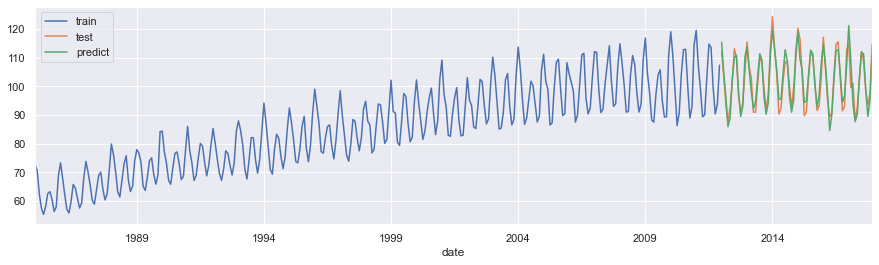

In [132]:
model_params = {
    'seasonal_periods': 12, 
    'trend': 'add',
    'seasonal': 'add', 
    'use_boxcox': True, 
    'initialization_method': "estimated"
}
fit_params = {'optimized': True}
fit_hwes_add = ts_one_step_forecast(ExponentialSmoothing, 'HWES_add', model_params=model_params, fit_params=fit_params)
fit_hwes_add.params

#### Triple Exponential Smoothing / Holt Winter’s Exponential Smoothing (HWES)
#### (multiplicative method)

The multiplicative level component formula:

$$ l_t = \alpha \frac{y_t}{s_{t-m}} + (1-\alpha)(l_{t-1}+b_{t-1}) $$<br>

The multiplicative trend component formula:

$$ b_t = \beta (l_t - l_{t-1}) + (1-\beta)b_{t-1} $$<br>

The multiplicative seasonal component formula:

$$ s_t = \gamma \frac{y_t}{(l_{t-1} + b_{t-1})} + (1-\gamma)s_{t-m} $$<br>

Integrate those three become:

$$ \hat{y}_{t+h} = (l_t + hb_t)s_{t+h-m(k+1)} $$


100%|██████████| 72/72 [00:12<00:00,  5.76it/s]


{'smoothing_level': 0.6314858586237007,
 'smoothing_trend': 3.943760928514429e-11,
 'smoothing_seasonal': 1.1721655830796883e-07,
 'damping_trend': nan,
 'initial_level': 74.09327447929876,
 'initial_trend': 1.001024094621684,
 'initial_seasons': array([1.62425308, 1.48815977, 1.37303018, 1.21264402, 1.22016368,
        1.36602707, 1.5024302 , 1.50397378, 1.34077221, 1.2250611 ,
        1.27438237, 1.49910989]),
 'use_boxcox': True,
 'lamda': 1.1501637085457348,
 'remove_bias': False}

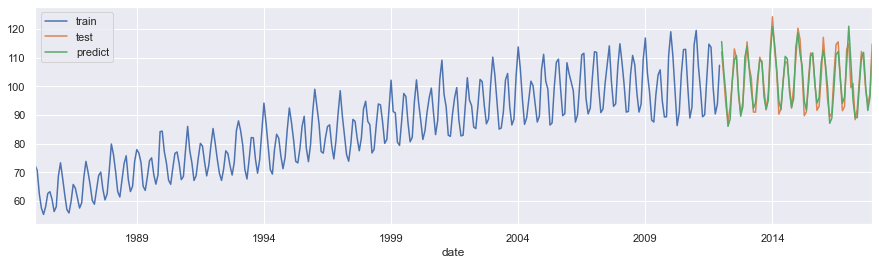

In [150]:
model_params = {
    'seasonal_periods': 12, 
    'trend': 'mul',
    'seasonal': 'mul', 
    'use_boxcox': True, 
    'initialization_method': "estimated"
}
fit_hwes_mul = ts_one_step_forecast(ExponentialSmoothing, 'HWES_mul', model_params=model_params)
fit_hwes_mul.params

### AR/ARIMA models


They are the most common models used in time series prediction so here just have a quick mention.

The autoregression model is to make prediction using the numbers of lags and each lags with one coefficient to imply the degree of its lag.
Most of the time the first lag meaning the previous day of time series value is MOST important as it is the closest current time of given observation. 

The ARIMA is to integrate the autoregressive variable and moving average (random noise) and use the differencing value between the past observation and true value instead of just directly use the past observation to put it into the model.

The functions below is to calculate the seasonal difference quickly for AR/ARIMA models.

The reverse function is to get back the true prediction value from differencing

In [134]:
#Function to calculate the time series difference by seasonal period
def ts_difference(ts, period=365, order=1):
    ts_tmp = ts.copy()
    for i in range(order):
        ts_tmp = ts_tmp.diff(periods = period)
    return ts_tmp

#Function to reverse time series difference for final results
def ts_difference_reverse(df, ts_pred, period=1):

    ts_pred_final = list()
    for k, v in ts_pred.items():
        
        prev_date = k - relativedelta(years=1)
        
        #Since 2012 and 2016 are leap year amongst the prediction period, one more day need to be added if Feb
        if ((prev_date.year  == 2012) or (prev_date.year == 2016)) and prev_date.month == 2:
            prev_date += pd.Timedelta(days=1)

        new_v = v + df[df.index == prev_date]
        ts_pred_final.append(new_v)

    # ts_pred_final = pd.Series(ts_pred_final, index=ts_pred.index)

    return ts_pred_final

# function to single-step forecast
def single_step_forecast_arima(model, model_abbr, df, train_len, 
                               model_params={}, fit_params={}, differencing=False, period=0):
    
    # get a copy of global dataframe to prevent inplace change
    df = df.copy(deep=True)
    df_apply = df.copy()
    df_train = df_apply.iloc[:train_len]
    df_test = df_apply.iloc[train_len:]

    # differencing
    if differencing is True:
        df_apply = ts_difference(df_apply, period=period)
    
    # rolling forecast
    ypred = list()
    for t in tqdm(range(len(df_test))):
        temp_train = df_apply.dropna().iloc[:train_len+t-period]
        m = model(temp_train, **model_params)
        fit = m.fit(**fit_params)
        predictions = fit.predict(start=len(temp_train), end=len(temp_train))
        ypred = ypred + [predictions]
    
    # concat series predictions to one series
    ypred = pd.concat(ypred)

    # reverse differencing
    if differencing is True:
        ypred = ts_difference_reverse(df, ypred)
        ypred = pd.concat(ypred)
        
    # save result
    ypred.index += pd.DateOffset(years=1)
    
    prediction[model_abbr] = ypred  
    evaluation[model_abbr] = evaluate(df_test, ypred)

    # show result
    plot_ts(df_train, df_test, ypred)

    return fit

Usually the seasonal differencing helps to make the time series data become stationary.

Based on the data visualization before, the seasonal period is 1-year.

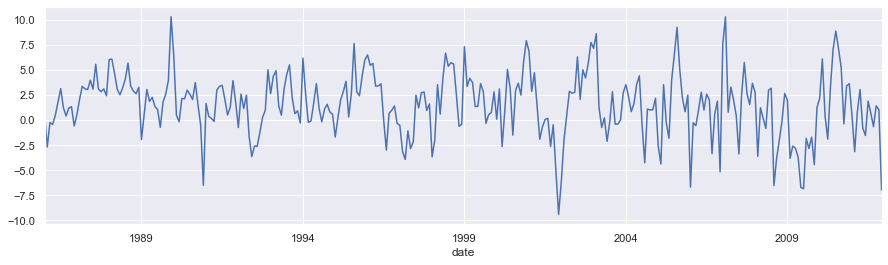

In [135]:
df_seasonal_diff = df.diff(12)
df_train_seasonal_diff = df_seasonal_diff.iloc[:len(df_train)].dropna()
df_test_seasonal_diff = df_seasonal_diff.iloc[len(df_test):]
df_train_seasonal_diff.plot();

We can use ADF test again to check the seasonal differenced time series.

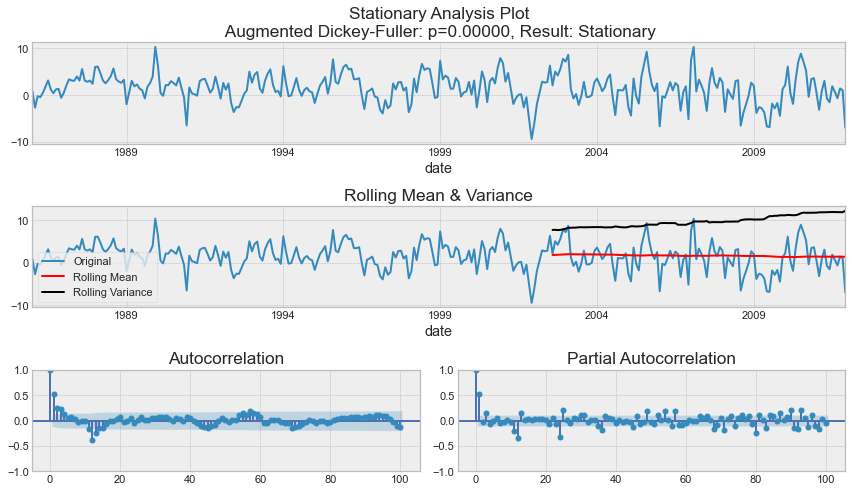

In [136]:
adf_test_and_tsplot(df_train_seasonal_diff)

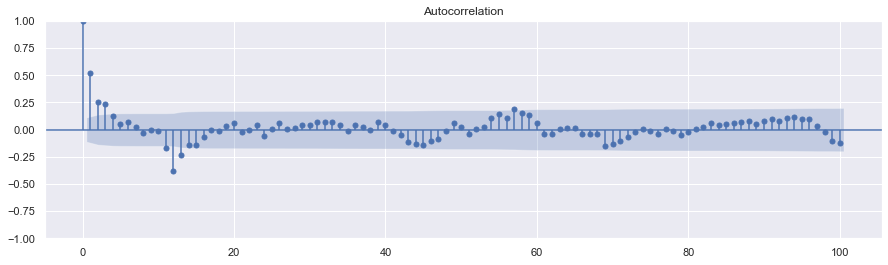

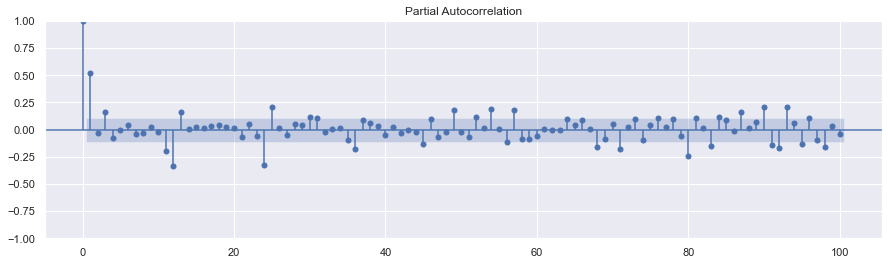

In [137]:
#Enlarge the acf and pacf plot

plot_acf(df_train_seasonal_diff, lags = 100, alpha=.05);
plot_pacf(df_train_seasonal_diff, lags = 100, alpha=.05);

### AR model

To build up the AR model, the pacf can help us to select numbers of lag.

We can still pick first 20 lags to see what is going to be happening.

100%|██████████| 72/72 [00:01<00:00, 66.41it/s]


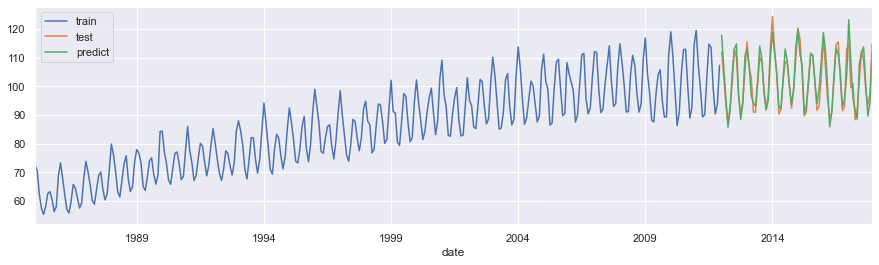

In [138]:
lags = np.arange(1,21)
model_params = {'lags': lags}
train_len = len(df_train)
args = {
    'model': AutoReg,
    'model_abbr': 'AR',
    'df': df,
    'train_len':train_len,
    'model_params': model_params,
    'differencing': True,
    'period': 12
}
fit_ar = single_step_forecast_arima(**args)

In [139]:
fit_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 amount   No. Observations:                  383
Model:                    AutoReg(20)   Log Likelihood                -867.178
Method:               Conditional MLE   S.D. of innovations              2.638
Date:                Sat, 03 Dec 2022   AIC                           1778.356
Time:                        23:54:06   BIC                           1864.032
Sample:                    09-30-1987   HQIC                          1812.412
                         - 11-30-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5572      0.198      2.810      0.005       0.169       0.946
amount.L1      0.5794      0.052     11.044      0.000       0.477       0.682
amount.L2     -0.1087      0.061     -1.792      0.073      -0.228       0.010
amount.L3      0.2125      0.061      3.483      0.000       0.093       0.332
amount.L4     -0.0941      0.062     -1.515      0.130      -0.216       0.028
amount.L5     -0.0106      0.062     -0.170      0.865      -0.133       0.112
amount.L6      0.0214      0.063      0.342      0.732      -0.101       0.144
amount.L7     -0.0188      0.063     -0.299      0.765      -0.142       0.105
amount.L8     -0.0225      0.063     -0.357      0.721      -0.146       0.101
amount.L9      0.0652      0.060      1.082      0.279      -0.053       0.183
amount.L10     0.0267      0.061      0.437      0.662      -0.093       0.146
amount.L11     0.1150      0.061      1.879      0.060      -0.005       0.235
amount.L12    -0.4374      0.062     -7.002      0.000      -0.560      -0.315
amount.L13     0.1468      0.067      2.197      0.028       0.016       0.278
amount.L14     0.0035      0.067      0.053      0.958      -0.128       0.135
amount.L15     0.0221      0.068      0.328      0.743      -0.110       0.154
amount.L16     0.0053      0.068      0.078      0.938      -0.127       0.138
amount.L17     0.0355      0.067      0.527      0.598      -0.097       0.168
amount.L18    -0.0104      0.066     -0.157      0.875      -0.141       0.120
amount.L19     0.0299      0.066      0.455      0.649      -0.099       0.159
amount.L20    -0.0176      0.056     -0.316      0.752      -0.127       0.092
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0522           -0.2848j            1.0901           -0.4579
AR.2            -1.0522           +0.2848j            1.0901            0.4579
AR.3            -0.7117           -0.7948j            1.0668           -0.3662
AR.4            -0.7117           +0.7948j            1.0668            0.3662
AR.5            -1.2383           -0.6539j            1.4003           -0.4227
AR.6            -1.2383           +0.6539j            1.4003            0.4227
AR.7            -0.2667           -1.0300j            1.0639           -0.2903
AR.8            -0.2667           +1.0300j            1.0639            0.2903
AR.9            -0.3671           -1.4565j            1.5020           -0.2893
AR.10           -0.3671           +1.4565j            1.5020            0.2893
AR.11            0.3064           -1.0346j            1.0790           -0.2042
AR.12            0.3064           +1.0346j            1.0790            0.2042
AR.13            0.8082           -0.7062j            1.0733           -0.1143
AR

The tables showed the strength of coefficient to each 20 lags.

We can conduct a statistical test to verify the coefficient whether it equals to 0 or not  by check the "P>|z|" column. If we set the $\alpha$ = 0.05, only the lag 1,3,12 and 13 are survive and others would reject because they are larger than 0.05.

### ARIMA model

In [140]:
params = {
    'y': df_train_seasonal_diff,
    'seasonal': False,                 
    'trace': True,
    'error_action': 'ignore',
    'suppress_warnings': True, 
    'n_jobs': -1,
}
autoModel = auto_arima(**params)
autoModel.fit(df_train)
order = autoModel.order
order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1506.919, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1665.969, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1515.281, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1544.749, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1506.074, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1534.707, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1516.767, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1506.875, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1522.783, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1510.364, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1508.845, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1497.222, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1504.984, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1500.984, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept

(0, 0, 4)

100%|██████████| 72/72 [00:10<00:00,  6.94it/s]


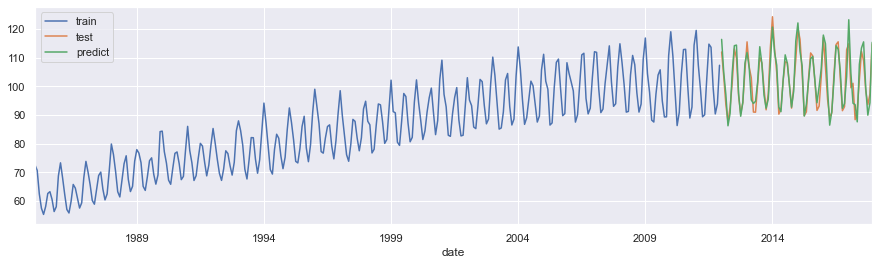

In [141]:
model_params = {'order': order}
args = {
    'model': ARIMA,
    'model_abbr': 'ARIMA',
    'df': df,
    'train_len': train_len,
    'model_params': model_params,
    'differencing': True,
    'period': 12
}
fit_arima = single_step_forecast_arima(**args)

### Summary on each models

Simple exponential smoothing (SES)

In [142]:
fit_ses.summary()

Dep. Variable:,amount,No. Observations:,395
Model:,SimpleExpSmoothing,SSE,23303.764
Optimized:,True,AIC,1614.606
Trend:,None,BIC,1622.564
Seasonal:,None,AICC,1614.709
Seasonal Periods:,None,Date:,"Sat, 03 Dec 2022"
Box-Cox:,False,Time:,23:54:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,72.504773,l.0,True


Double Exponential Smoothing / Holt's Linear Trend Method

In [143]:
fit_hlt.summary()

Dep. Variable:,amount,No. Observations:,395
Model:,Holt,SSE,23302.199
Optimized:,True,AIC,1618.580
Trend:,Additive,BIC,1634.495
Seasonal:,None,AICC,1618.796
Seasonal Periods:,None,Date:,"Sat, 03 Dec 2022"
Box-Cox:,False,Time:,23:54:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


Damped Trend Method

In [144]:
fit_hlt_damped.summary()

Dep. Variable:,amount,No. Observations:,395
Model:,Holt,SSE,23274.008
Optimized:,True,AIC,1620.102
Trend:,Additive,BIC,1639.996
Seasonal:,None,AICC,1620.391
Seasonal Periods:,None,Date:,"Sat, 03 Dec 2022"
Box-Cox:,False,Time:,23:54:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


Triple Exponential Smoothing / Holt Winter’s Exponential Smoothing (HWES)
(Additive method)

In [145]:
fit_hwes_add.summary()

Dep. Variable:,amount,No. Observations:,395
Model:,ExponentialSmoothing,SSE,2478.725
Optimized:,True,AIC,757.463
Trend:,Additive,BIC,821.125
Seasonal:,Additive,AICC,759.282
Seasonal Periods:,12,Date:,"Sat, 03 Dec 2022"
Box-Cox:,True,Time:,23:54:19
Box-Cox Coeff.:,1.15016,,
,coeff,code,optimized
smoothing_level,0.4832717,alpha,True
smoothing_trend,9.7699e-07,beta,True


Triple Exponential Smoothing / Holt Winter’s Exponential Smoothing (HWES)
(Multiplicative method)

In [146]:
fit_hwes_mul.summary()

Dep. Variable:,amount,No. Observations:,395
Model:,ExponentialSmoothing,SSE,2168.242
Optimized:,True,AIC,704.600
Trend:,Multiplicative,BIC,768.263
Seasonal:,Multiplicative,AICC,706.420
Seasonal Periods:,12,Date:,"Sat, 03 Dec 2022"
Box-Cox:,True,Time:,23:54:19
Box-Cox Coeff.:,1.15016,,
,coeff,code,optimized
smoothing_level,0.6314859,alpha,True
smoothing_trend,3.9438e-11,beta,True


ARIMA model

In [147]:
fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 amount   No. Observations:                  383
Model:                 ARIMA(0, 0, 4)   Log Likelihood                -937.474
Date:                Sat, 03 Dec 2022   AIC                           1886.948
Time:                        23:54:20   BIC                           1910.636
Sample:                    01-31-1986   HQIC                          1896.344
                         - 11-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2520      0.310      4.035      0.000       0.644       1.860
ma.L1          0.5687      0.043     13.202      0.000       0.484       0.653
ma.L2          0.1871      0.056      3.368      0.001       0.078       0.296
ma.L3          0.2308      0.060      3.878      0.000       0.114       0.347
ma.L4          0.1350      0.052      2.591      0.010       0.033       0.237
sigma2         7.8177      0.483     16.184      0.000       6.871       8.764
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                13.80
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model evaluations

The performance metrics include MAE, RMSE, R2, MAPE.

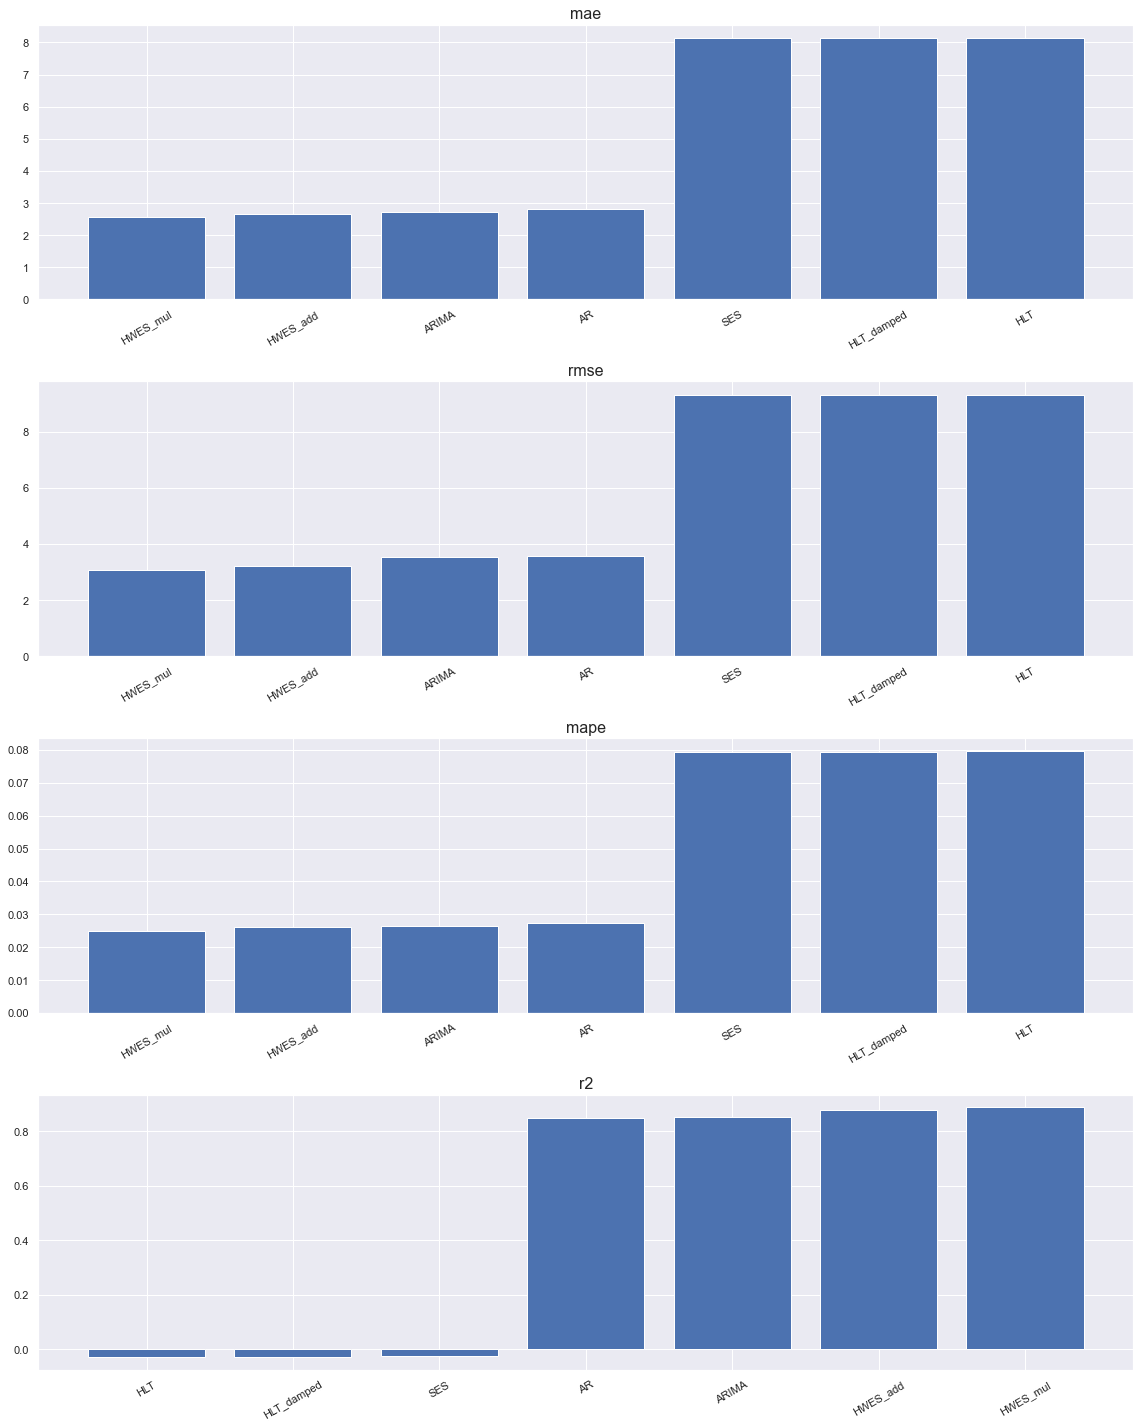

In [148]:
metrics = ['mae', 'rmse', 'mape', 'r2']
fig, axes = plt.subplots(4, 1, figsize=(16, 20))
scores_dict = {}

for i, metric in enumerate(metrics):
    
    # get scores of each metric and sort
    scores_dict[metric] = []
    for k, d in evaluation.items():
        scores_dict[metric].append((k, d[metric]))
    scores_dict[metric] = sorted(scores_dict[metric], key=lambda x:x[1], reverse=False)
    x, y = zip(*scores_dict[metric])
    # plot bar char in descending order of score
    ax = axes[i]
    ax.bar(x, y)
    ax.set_title(metric, fontsize=16)
    ax.set_xticklabels(x, rotation=30)

fig.tight_layout() 
plt.show()

WOW! The HWES mutiplicative method model is the best in all metrics.
I guess the reason is the seasonality appears quite obviously and the fluncations may indicates some mutiplicative patterns.

Finally, the HWES multiplicative method model is the best model!

Thanks for viewing my work!
Please upvote if you love it!